# Description 

In this notebook, you will be able to rebin all the images in pixels. 

1. you will need to select an image to define and check the rebin parameter. Only even factors of the image size will be allowed. 

2. program will perform the rebin on all the other images from the data folder

# Import Python Modules

In [1]:
verbose = False
debugging = False
ipts_group = 'IPTS_14832'

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

if os.sys.platform == 'darwin':
    pass
else:
    pass

import config_handler
import file_handler
import math_handler
import utilities
import gui_widgets

display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (above cell): we are importing all \
        the python libraries</span>\
        <br><br><span style="font-size: 20px; color:blue"><b>Make sure you wait until a cell\
        is done executing before running another cell!</span>'))

In [2]:
%gui qt

display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (above cell): Starting with this one!</span>'))

# Select Folders of Images to Rebin 

In [115]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (above cell): select the parent folder of images \
for which you want to rebin the pixels of the images!</span>'))

data_folder = config_handler.load_config(key='data_folder',
                                        default_value = '/Volumes/my_book_thunderbolt_duo/IPTS/IPTS_14832/',
                                        group=ipts_group)
new_data_folder = gui_widgets.gui_dname(dir=data_folder,
                                       message = 'Select Parent Folder that Contains all the Images to Rebin...')

if new_data_folder:
    config_handler.save_config(key='data_folder', value=new_data_folder, group=ipts_group)
    unclean_folders = glob.glob(new_data_folder + '/*')
    list_of_folders = [_folder for _folder in unclean_folders if os.path.isdir(_folder)]
    print("Number of Folders: {}".format(len(list_of_folders)))
    short_list_of_folders = [os.path.basename(_folder) for _folder in list_of_folders]

Number of Folders: 51


# Preview Rebinning

## Select Image you want to use to check rebinning

In [116]:
image_to_check = widgets.Dropdown(options=short_list_of_folders,
                              value=short_list_of_folders[0],
                                 description='Select Image to Preview:')
display(image_to_check)

display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (above cell): select the folder (image) \
you want to use to check the rebinning algorithm!</span>'))


## Loading image selected

In [117]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (above cell): program is loading all the images \
of the folder you selected: <b>' + image_to_check.value + '</b> !</span>'))

list_of_files = glob.glob(os.path.join(new_data_folder, image_to_check.value) + '/*.fits')

w = widgets.IntProgress()
w.max = len(list_of_files)
display(w)

data_array = []
for _index, _file in enumerate(list_of_files):
    _image = file_handler.read_single_fits(_file)
    data_array.append(_image)
    w.value = _index+1

## Select rebin value

In [118]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (above cell): Select rebin value. \
The list is populated according to the size of the image (only factors of the image dimension in order \
to not loose any pixels)!</span>'))

[height, width] = np.shape(data_array[0])

initial_list_of_bins = np.arange(2, 21)
clean_list_of_bins = []
for _bin in initial_list_of_bins:
    if (np.floor(height/_bin) == height/_bin) and \
    np.floor(width/_bin) == width/_bin:
        clean_list_of_bins.append(_bin)
  
selected_bin_value = widgets.Dropdown(options=clean_list_of_bins,
                              value=clean_list_of_bins[0],
                                     description='Bin value:')
display(selected_bin_value)


## Rebin Image

In [124]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (above cell): rebinning all the images \
from the folder you selected.</span>'))

def rebin_array(data=[], bin_value=1, new_dim=1):
    data = data.reshape([new_dim, bin_value, new_dim, bin_value]).mean(3).mean(1)
    return data

w = widgets.IntProgress()
w.max = len(list_of_files)
display(w)

bin_value = np.int(selected_bin_value.value)
new_dim = np.int(height/bin_value)

rebin_data_array = []
for _index, _data in enumerate(data_array):
#    _rebin_image = _data.reshape([new_dim, bin_value, new_dim, bin_value]).mean(3).mean(1)
    _rebin_image = rebin_array(data=_data, bin_value=bin_value, new_dim=new_dim)
    rebin_data_array.append(_rebin_image)
    w.value = _index+1

## Preview result (before and after rebinning)

In [125]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (below cell): raw image vs rebinned image<br> \
                Feel free to browse through the list of files!</span>'))

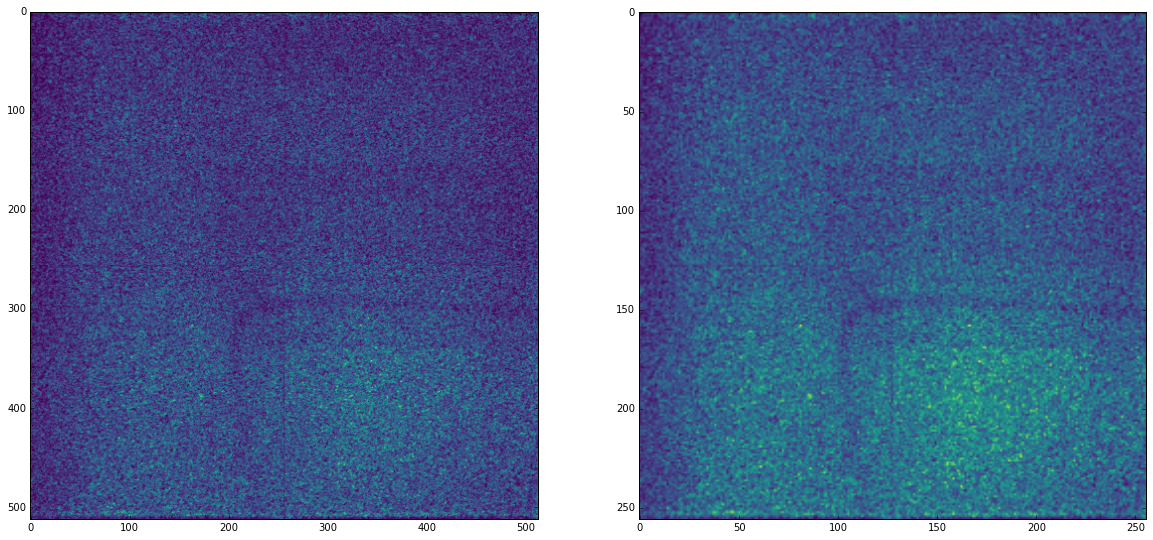

In [126]:
def preview_result(file_index):
    
    fig = plt.figure(figsize=(20,20))
    ax_before = plt.subplot(121)
    ax_before.imshow(data_array[file_index], cmap='viridis')
    
    ax_after = plt.subplot(122)
    ax_after.imshow(rebin_data_array[file_index], cmap='viridis')
    
preview = interact(preview_result,
                  file_index = widgets.IntSlider(min=0,
                                                max = len(list_of_files)-1,
                                                description='Image Index'))
    

# Export Images Rebinned

In [127]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (below cell): Select the final location \
    where you want all the rebinned images to be created. The program will then create a </span> \
    <span style="font-size: 20px"><i>name_of_source_folder_REBIN</i></span><span style="font-size: 20px; color:blue"> \
             folder for you \
    in that location.</span>'))

In [128]:
output_folder = config_handler.load_config(key='output_folder', 
                                           default_value = data_folder,
                                           group=ipts_group)
rebinned_output_folder = gui_widgets.gui_dname(dir = output_folder,
                                       message = 'Select Ouptut Folder ...')

In [132]:
w = widgets.IntProgress()
w.max = len(list_of_folders)
w.description = "Load & rebin!"
display(w)

new_top_folder = os.path.join(rebinned_output_folder, os.path.basename(new_data_folder) + '_rebin')
file_handler.make_or_reset_folder(new_top_folder)

for _index, _folder in enumerate(list_of_folders):
    _list_of_files = glob.glob(_folder + '/*.fits')
    _new_bin_folder = os.path.join(new_top_folder, os.path.basename(_folder))
    file_handler.make_or_reset_folder(_new_bin_folder)
    
    _data_rebin = []
    for _file in _list_of_files:
        _data = file_handler.read_single_fits(_file)
        _rebin_image = rebin_array(data=_data, bin_value=bin_value, new_dim=new_dim)
        new_file_name = os.path.join(_new_bin_folder, os.path.basename(_file))
        file_handler.make_fits(data=_rebin_image, filename=new_file_name)
        
    w.value = _index+1
    
